In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor

import scanpy as sc

from sklearn.metrics import mean_squared_error

package_path = "/home/boris/haxx/vae_only/"

import sys
sys.path.append(package_path)

from vae_external import VanillaVAE

from utils import double_agg,single_agg
from utils import concordance_plot

from os.path import join as path_join
import os


plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.aspect'] = 'auto'


# Data Setup

In [2]:
data_loc = "/fast2/bmb/tabula_muris_working/"
data = sc.read(path_join(data_loc,"interesting.h5ad"))


In [3]:
def split_data(data,shuffle=None,validation_split=20000):

    if shuffle is None:
        shuffle = np.arange(data.X.shape[0])
        np.random.shuffle(shuffle)
        
    data_training = data[shuffle[:-validation_split]]
    data_validation = data[shuffle[-validation_split:]]
    
    return {'training':data_training,'validation':data_validation,'shuffle':shuffle}

split = split_data(data)
data_training = split['training']
data_validation = split['validation']
extract_training = np.array(data_training.X.todense())
extract_validation = np.array(data_validation.X.todense())

In [4]:

from utils import permute_dictionary

permutation_dictionary = {
    'kld_weight': [1e-3,1e-4,1e-5,1e-6,0,],
    'learning_rate': [1e-3,1e-4,1e-5],
    'weight_decay': [1e-5,1e-6,1e-7,0],
    # 'model_dim':[30,60,100],
}

permuted = permute_dictionary(permutation_dictionary)
permuted


[{'kld_weight': 0.001, 'learning_rate': 0.001, 'weight_decay': 1e-05},
 {'kld_weight': 0.001, 'learning_rate': 0.001, 'weight_decay': 1e-06},
 {'kld_weight': 0.001, 'learning_rate': 0.001, 'weight_decay': 1e-07},
 {'kld_weight': 0.001, 'learning_rate': 0.001, 'weight_decay': 0},
 {'kld_weight': 0.001, 'learning_rate': 0.0001, 'weight_decay': 1e-05},
 {'kld_weight': 0.001, 'learning_rate': 0.0001, 'weight_decay': 1e-06},
 {'kld_weight': 0.001, 'learning_rate': 0.0001, 'weight_decay': 1e-07},
 {'kld_weight': 0.001, 'learning_rate': 0.0001, 'weight_decay': 0},
 {'kld_weight': 0.001, 'learning_rate': 1e-05, 'weight_decay': 1e-05},
 {'kld_weight': 0.001, 'learning_rate': 1e-05, 'weight_decay': 1e-06},
 {'kld_weight': 0.001, 'learning_rate': 1e-05, 'weight_decay': 1e-07},
 {'kld_weight': 0.001, 'learning_rate': 1e-05, 'weight_decay': 0},
 {'kld_weight': 0.0001, 'learning_rate': 0.001, 'weight_decay': 1e-05},
 {'kld_weight': 0.0001, 'learning_rate': 0.001, 'weight_decay': 1e-06},
 {'kld_weigh

In [5]:

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')

model_parameters = {
    'input_dim': 5000,
    'model_dim': 20,
    'batch_size': 500,
    'kld_weight':1e-4,
    'learning_rate':1e-4,
    'weight_decay':1e-6
}


training_parameters = {
    'training_set':None,
    'validation_set':None,
    'num_iter':20000,
    'logging_frequency':1000,
    'device':cuda0,
}

model_path = "/fast2/bmb/tabula_muris_working/vae_scan/"

In [ ]:

for pd_index,pd in list(enumerate(permuted)):

    permutation_path = path_join(model_path,f"ensemble_{pd_index}")
    try:
        os.mkdir(permutation_path)
    except FileExistsError:
        pass

    permuted_model_parameters = model_parameters | {k:v for k,v in pd.items() if k in model_parameters}
    permuted_training_parameters = training_parameters | {k:v for k,v in pd.items() if k in training_parameters}
    print(f"Training permutation {permuted_model_parameters} \n {permuted_training_parameters}")

    for e in range(10):
        
        split = split_data(data)
        
        extract_training = np.array(split['training'].X.todense())
        extract_validation = np.array(split['validation'].X.todense())
    
        permuted_training_parameters['training_set'] = extract_training
        permuted_training_parameters['validation_set'] = extract_validation
    
        model = VanillaVAE(**permuted_model_parameters)
        model.to(cuda0)
        model.train(**permuted_training_parameters)
        model.save(path_join(permutation_path,f"vae_{e}.trch"))

Training permutation {'input_dim': 5000, 'model_dim': 20, 'batch_size': 500, 'kld_weight': 1e-05, 'learning_rate': 0.001, 'weight_decay': 1e-06} 
 {'training_set': None, 'validation_set': None, 'num_iter': 20000, 'logging_frequency': 1000, 'device': device(type='cuda', index=0)}
Step:0,RL:0.2323719710111618,KLD:-0.20393690466880798
Step:0,VRL:0.22951839864253998
Step:1000,RL:0.19526614248752594,KLD:-31.172927856445312
Step:1000,VRL:0.18980035185813904


KeyboardInterrupt: 

# Reload

In [6]:

split = split_data(data)
data_training = split['training']
data_validation = split['validation']
extract_training = np.array(data_training.X.todense())
extract_validation = np.array(data_validation.X.todense())


In [7]:
model_path = "/fast2/bmb/tabula_muris_working/vae_scan/"

ensemble_member_names = os.listdir(model_path)
ensemble_member_paths = [path_join(model_path,enm) for enm in ensemble_member_names if ".param" not in enm]
ensemble_member_paths

['/fast2/bmb/tabula_muris_working/vae_scan/ensemble_6.png',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_4.png',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_3',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_50',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_24',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_5.png',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_20',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_40',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_18',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_35',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_49',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_4',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_42',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_30',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_8',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_39',
 '/fast2/bmb/tabula_muris_working/vae_scan/ensemble_54',
 '/fast2/bmb/tabula_muris

(400, 400)
Failed {'input_dim': 5000, 'model_dim': 20, 'hidden_dims': None, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'batch_size': 500, 'kld_weight': 0.001}
(400, 400)


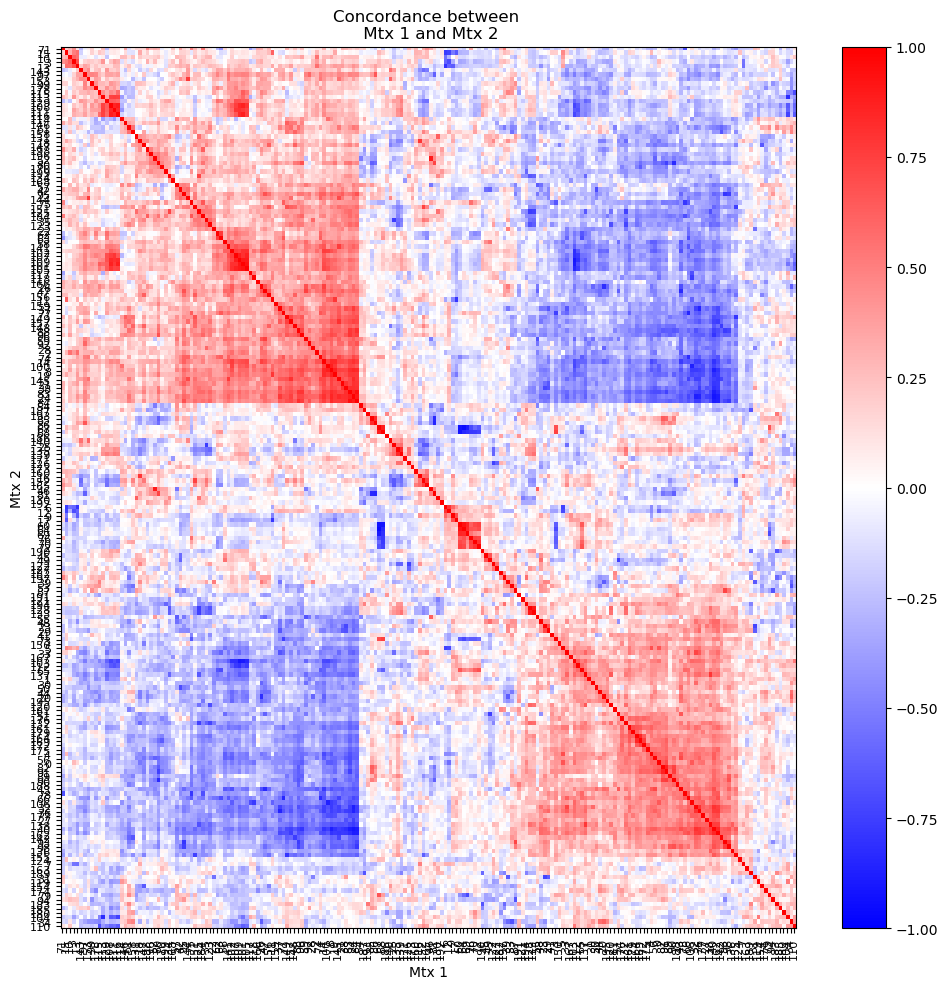

(400, 400)
Failed {'input_dim': 5000, 'model_dim': 20, 'hidden_dims': None, 'learning_rate': 0.001, 'weight_decay': 1e-07, 'batch_size': 500, 'kld_weight': 0.001}


KeyboardInterrupt: 

In [ ]:
for e_i,ensemble_path in enumerate([path_join(model_path,f"ensemble_{i}") for i in range(60)]):

    ensemble_member_names = os.listdir(ensemble_path)
    ensemble_member_paths = [path_join(ensemble_path,enm) for enm in ensemble_member_names if ".param" not in enm]
    ensemble_member_paths

    joint = []
    for path in ensemble_member_paths:
        model = VanillaVAE.load(path) 
        res = model.embeddings(Tensor(extract_validation))
        joint.append(res['means'].detach().numpy())
    
    joint = np.concatenate(joint,axis=1)
    joint.shape

    try:
        concordance_plot(joint,joint,plot_text=False,agglomerate=True,metric='correlation',path=path_join(model_path,f"ensemble_{e_i}.png"))
    except ValueError:
        print(f"Failed {model.argset}")
        continue